# A. Informationen zum Notebook

<p>Herausgeber: Koordinierungsstelle Bildungsmonitoring (KOSMO)</p>
<p>Version: X.X.X (XX.XX.2023)<p/>
<p>DOI: XXX</p>
<p>Dieses Notebook dient dazu, Gemeindedaten der Bundesagentur fuer Arbeit (BA) mit Bevoelkerungsdaten des Statistischen Bundesamtes (Destatis) zu verknuepfen, um daraus gemeindespezifische SGB-II-Quoten berechnen zu koennen. Hierbei wird auf folgende Originaldaten der BA und von Destatis zugegriffen, die von den entsprechenden Stellen bezogen werden koennen: </p>

- Genaue Zitation BA-Daten
- Genaue Zitation Destatis-Daten

Um die Aufbereitung der Daten korrekt durchfuehren zu koennen, muuessen diese Notebook-Datei (.ipynb) sowie die Originaldaten bzw. -dateien der BA und von Destatis in einem lokalen Ordner gespeichert werden.

# 0. Vorbereitung der Daten

In [1]:
# Benoetigte Pakete importieren
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Begrenzung der Spaltendarstellung deaktivieren
pd.set_option("display.max_columns", None)

In [3]:
# Einlesen der Gemeindedaten der Bundesagentur fuer Arbeit (BA) aus den Jahren 2014 bis 2021

# Dateinamen und Tabellennamen abrufen
file_names = [
    ("230328_EA_338634_Gemeindedaten_Teil1.xlsx", "2014"),
    ("230328_EA_338634_Gemeindedaten_Teil2.xlsx", "2015"),
    ("230328_EA_338634_Gemeindedaten_Teil2.xlsx", "2016"),
    ("230328_EA_338634_Gemeindedaten_Teil3.xlsx", "2017"),
    ("230328_EA_338634_Gemeindedaten_Teil3.xlsx", "2018"),
    ("230328_EA_338634_Gemeindedaten_Teil4.xlsx", "2019"),
    ("230328_EA_338634_Gemeindedaten_Teil4.xlsx", "2020"),
    ("230328_EA_338634_Gemeindedaten_Teil5.xlsx", "2021")
]

# Dictionary fuer die Dataframes erstellen
dataframes = {}

# Ueber Dateien und Tabellennamen iterieren
for file_name, sheet_name in file_names:
    # Spezifisches Tabellenblatt in einen DataFrame einlesen
    df = pd.read_excel(file_name, sheet_name=sheet_name)
    # DataFrame im Dictionary speichern
    dataframes["ba_" + sheet_name] = df

# Zugriff auf die Dataframes
ba_2014 = dataframes["ba_2014"]
ba_2015 = dataframes["ba_2015"]
ba_2016 = dataframes["ba_2016"]
ba_2017 = dataframes["ba_2017"]
ba_2018 = dataframes["ba_2018"]
ba_2019 = dataframes["ba_2019"]
ba_2020 = dataframes["ba_2020"]
ba_2021 = dataframes["ba_2021"]

In [4]:
# Daten (Beispiel 2021) inspizieren
ba_2021.head(20)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Grundsicherung für Arbeitsuchende (SGB II)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Eckwerte der Grundsicherung nach Gemeinden,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Deutschland - Gemeinden (Gebietsstand Dezember...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Jahresdurchschnitt 2021, Datenstand: März 2023",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Daten zu Leistungen nach dem SGB II nach einer...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Gemeinde,Leistungs-berechtigte (LB),Insgesamt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,darunter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Männer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Frauen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,dar. (Sp. 1) im Alter von ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dar. (Sp. 1),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Leistungs-berechtigte (LB),dar. (Sp. 25) im Alter von ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dar. (Sp

# 1. BA-Daten umformen

### 1.1 Grundlegende Umformung der Ausgangsdaten

In [5]:
# Funktion zur Transformation der Daten definieren
def transform_dataframe(df):
    # Zeilen 0 bis 7 entfernen
    df = df.drop(df.index[0:7])
    
    # Letzte Zeile entfernen
    df = df.drop(df.index[-1])
    
    # Spalte 'Unnamed: 0' nach Leerzeichen trennen und in neue Spalten 'AGS' und 'Gemeinde' aufteilen
    df[['AGS', 'Gemeinde']] = df['Unnamed: 0'].str.split(' ', 1, expand=True)
    
    # Spalte 'Unnamed: 0' entfernen
    df = df.drop(['Unnamed: 0'], axis=1)
    
    # Erstellen einer Kontrollspalte 'Gesamtwerte_Kontrolle' mit den Spalten 'AGS', 'Gemeinde' und 'Unnamed: 1'
    Gesamtwerte_Kontrolle = df[['AGS', 'Gemeinde', 'Unnamed: 1']].copy()
    
    # Spalte 'Unnamed: 1' entfernen
    df.drop(['Unnamed: 1'], axis=1, inplace=True)
    
    # Nur Spalten ab der 23. Spalte behalten
    df = df.iloc[:, 23:]
    
    # Fehlende Werte in Zeile 5 mit den Werten der vorherigen Zeilen fuellen
    df.iloc[5] = df.iloc[5].fillna(df.iloc[4])
    df.iloc[5] = df.iloc[5].fillna(df.iloc[3])
    df.iloc[5] = df.iloc[5].fillna(df.iloc[2])
    
    # Zeilen 7, 9, 10, 11 und 13 entfernen
    df = df.drop([7, 9, 10, 11, 13])
    
    # Letzte beiden Werte in Zeile 1 mit den Werten der letzten beiden Spaltennamen fuellen
    df.iloc[1, -1] = df.columns[-1]
    df.iloc[1, -2] = df.columns[-2]
    
    # Neue Spaltennamen aus Zeile 1 erstellen
    new_columns = df.iloc[1].tolist()
    
    # Spaltennamen aktualisieren
    df = df.set_axis(new_columns, axis=1, inplace=False)
    
    # Zeile 12 entfernen
    df = df.drop(12)
    
    # Transformiertes DataFrame zurueckgeben
    return df

# Definierte Funktion auf die Daten anwenden und damit Dataframes erstellen
ba_2014 = transform_dataframe(ba_2014)
ba_2015 = transform_dataframe(ba_2015)
ba_2016 = transform_dataframe(ba_2016)
ba_2017 = transform_dataframe(ba_2017)
ba_2018 = transform_dataframe(ba_2018)
ba_2019 = transform_dataframe(ba_2019)
ba_2020 = transform_dataframe(ba_2020)
ba_2021 = transform_dataframe(ba_2021)

C:\Users\tobias.vetterle\AppData\Local\Temp\ipykernel_5704\697503413.py:10: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[['AGS', 'Gemeinde']] = df['Unnamed: 0'].str.split(' ', 1, expand=True)
C:\Users\tobias.vetterle\AppData\Local\Temp\ipykernel_5704\697503413.py:40: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df = df.set_axis(new_columns, axis=1, inplace=False)
C:\Users\tobias.vetterle\AppData\Local\Temp\ipykernel_5704\697503413.py:10: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[['AGS', 'Gemeinde']] = df['Unnamed: 0'].str.split(' ', 1, expand=True)
C:\Users\tobias.vetterle\AppData\Local\Temp\ipykernel_5704\697503413.py:40: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecate

In [6]:
# Daten (Beispiel 2018) inspizieren
ba_2018.head()

,Leistungs-berechtigte (LB),unter 65 Jahren,unter 15 Jahren,unter 3 Jahren,3 bis unter 6 Jahren,6 bis unter 15 Jahren,15 bis unter 18 Jahren,18 bis unter 25 Jahren,25 bis unter 65 Jahren,15 bis unter 18 Jahren (Kinder),Erwerbs-fähige Leistungs-berechtigte (ELB),erziehende ELB,allein-erziehende ELB,arbeit-suchende ELB insgesamt,kein Hauptschul-abschluss,Hauptschul-abschluss,mittlere Reife,Fachhoch-schule,Abitur/ Hochschul-reife,keine Angabe,ohne abge-schlossene Berufs-ausbildung,betriebliche/schulische Ausbildung,akade-mische Ausbildung,keine Angabe,Leistungs-berechtigte (LB),unter 65 Jahren,unter 15 Jahren,unter 3 Jahren,3 bis unter 6 Jahren,6 bis unter 15 Jahren,15 bis unter 18 Jahren,18 bis unter 25 Jahren,25 bis unter 65 Jahren,15 bis unter 18 Jahren (Kinder),Erwerbs-fähige Leistungs-berechtigte (ELB),erziehende ELB,allein-erziehende ELB,arbeit-suchende ELB insgesamt,kein Hauptschul-abschluss,Hauptschul-abschluss,mittlere Reife,Fachhoch-schule,Abitur/ Hochschul-reife,keine Angabe,ohne abge-schlossene Berufs-ausbildung,betriebliche/schulische Ausbildung,akade-mische Ausbildung,keine Angabe,AGS,Gemeinde
8,Männer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Frauen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,6128.666667,6117.916667,1561.5,378.75,341.166667,841.583333,229.75,741.666667,3585,219.833333,4499,949.25,101,3487.5,707.75,1321.833333,457.583333,210.416667,388.75,401.166667,2415.083333,903.083333,167.333333,2,5643.083333,5631.25,1571.833333,396.25,330.083333,845.5,208,676.666667,3174.75,199.083333,3974,1950.5,1077.666667,2442.583333,416.083333,933.5,396.5,88.75,223.666667,384.083333,1628.666667,724.333333,87.25,2.333333,01001000,"Flensburg, Stadt"
15,17856,17793.5,4702.666667,1010.416667,985.416667,2706.833333,771.916667,1870.083333,10448.833333,742.583333,12939.083333,3024.25,186.916667,9929.666667,2238.25,3303.833333,1309.166667,523.916667,1707.916667,846.583333,6687.333333,2449.666667,789.083333,3.583333,16340.416667,16293.666667,4562.416667,993.833333,930.833333,2637.75,707.083333,1609.75,9414.416667,677.25,11555.5,5476.583333,2516.083333,7028.583333,1520.166667,2319.166667,1166.75,315.666667,1036.666667,670.166667,4652.666667,1829.083333,542.833333,4,01002000,"Kiel, Landeshauptstadt"
16,13417.833333,13344.666667,3785.833333,824.083333,803.75,2158,599.583333,1231.583333,7727.666667,579.583333,9471.166667,2197.916667,163.25,7217.666667,1469.5,2749.333333,961.416667,380.416667,574.75,1082.25,4873.916667,2011.75,329.333333,2.666667,12890,12834.166667,3357.916667,693.25,717.666667,1947,543.416667,1218.5,7714.333333,524.583333,9347.25,4388.666667,2277.583333,5824.166667,1027.833333,2093.083333,1005.916667,252,491.416667,953.916667,3802.25,1756.75,263.333333,1.833333,01003000,"Lübeck, Hansestadt"
17,4778.916667,4760.5,1312.083333,280.666667,284.833333,746.583333,216.833333,506.75,2724.833333,210.25,3358.583333,804,65,2581.916667,605.75,1091.916667,284,77.333333,147.666667,375.25,1870.25,656.75,54.416667,0.5,4680.833333,4658.583333,1295.916667,264.583333,287.666667,743.666667,171,553.25,2638.416667,160.5,3284.25,1630.333333,874.666667,2077.083333,454.083333,889.833333,256.083333,34.416667,98.25,344.416667,1543.5,494.416667,38.333333,0.833333,01004000,"Neumünster, Stadt"


### 1.2 Spalte fuer Geschlecht ergaenzen und Tabelle entsprechend stapeln

In [7]:
# Funktion zur Transformation der Daten definieren
def apply_transformation(df):
    # Daten (maennlich) aus den ersten 24 Spalten und den Spalten 48 und 49 extrahieren
    df_m = df.iloc[:, list(range(24)) + [48, 49]]
    
    # Daten (weiblich) aus den Spalten 24 bis 49 extrahieren
    df_w = df.iloc[:, 24:50]
    
    # Geschlecht fuer Daten (weiblich) auf "w" setzen
    df_w.loc[:, "Geschlecht"] = "w"
    
    # Geschlecht fuer Daten (maennlich) auf "m" setzen
    df_m.loc[:, "Geschlecht"] = "m"
    
    # Zeile 8 aus Daten (weiblich) entfernen
    df_w = df_w.drop([8])
    
    # Zeile 8 aus Daten (maennlich) entfernen
    df_m = df_m.drop([8])
    
    # Daten (maennlich und weiblich) zu einem DataFrame kombinieren
    combined_df = df_m.append(df_w, ignore_index=True)
    
    # Spalten umbenennen, indem Bindestriche "-" entfernt werden
    combined_df = combined_df.rename(columns=lambda x: x.replace('-', ''))
    
    return combined_df

# Definierte Funktion auf die Daten anwenden und damit Dataframes transformieren
ba_2014_combined = apply_transformation(ba_2014)
ba_2015_combined = apply_transformation(ba_2015)
ba_2016_combined = apply_transformation(ba_2016)
ba_2017_combined = apply_transformation(ba_2017)
ba_2018_combined = apply_transformation(ba_2018)
ba_2019_combined = apply_transformation(ba_2019)
ba_2020_combined = apply_transformation(ba_2020)
ba_2021_combined = apply_transformation(ba_2021)

C:\Users\tobias.vetterle\AppData\Local\Temp\ipykernel_5704\787215793.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w.loc[:, "Geschlecht"] = "w"
C:\Users\tobias.vetterle\AppData\Local\Temp\ipykernel_5704\787215793.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m.loc[:, "Geschlecht"] = "m"
C:\Users\tobias.vetterle\AppData\Local\Temp\ipykernel_5704\787215793.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inst

In [8]:
# Daten (Beispiel 2014) inspizieren
ba_2014_combined.head()

,Leistungsberechtigte (LB),unter 65 Jahren,unter 15 Jahren,unter 3 Jahren,3 bis unter 6 Jahren,6 bis unter 15 Jahren,15 bis unter 18 Jahren,18 bis unter 25 Jahren,25 bis unter 65 Jahren,15 bis unter 18 Jahren (Kinder),Erwerbsfähige Leistungsberechtigte (ELB),erziehende ELB,alleinerziehende ELB,arbeitsuchende ELB insgesamt,kein Hauptschulabschluss,Hauptschulabschluss,mittlere Reife,Fachhochschule,Abitur/ Hochschulreife,keine Angabe,ohne abgeschlossene Berufsausbildung,betriebliche/schulische Ausbildung,akademische Ausbildung,keine Angabe,AGS,Gemeinde,Geschlecht
0,5243.25,5236.416667,1198.083333,273.666667,236.833333,687.583333,198.25,576.333333,3263.75,193,3956.25,697.666667,84.75,3215.666667,564.083333,1606.083333,472,174.583333,174,224.916667,1984.5,1101.75,87.75,41.666667,01001000,"Flensburg, Stadt",m
1,16628.916667,16599.75,4059.833333,888.333333,834.25,2337.25,684.75,1519.333333,10335.833333,670.166667,12245.083333,2532.166667,177.166667,9485.75,1735.083333,4051.833333,1469.75,509.5,1110.916667,608.666667,5776.25,3057.75,533.5,118.25,01002000,"Kiel, Landeshauptstadt",m
2,13740.583333,13711.583333,3487,745.166667,707.583333,2034.25,588.916667,1278.916667,8356.75,579.583333,10053.916667,2136.166667,160.166667,7943.333333,1408.916667,3825.75,1176.25,394.5,453.083333,684.833333,4916.416667,2600.833333,241.333333,184.75,01003000,"Lübeck, Hansestadt",m
3,5154.416667,5144.416667,1287.083333,268.833333,241.25,777,242.5,501.333333,3113.5,236.166667,3761.916667,843.333333,78.5,2972.75,653.25,1499.5,339.916667,71.583333,116.833333,291.666667,1914.166667,963.916667,41.75,52.916667,01004000,"Neumünster, Stadt",m
4,198,197,57.666667,17,7.166667,33.5,4.25,18.083333,117,4.25,136.5,27.5,1.166667,110.25,24.083333,60.25,13.083333,2.25,4.416667,6.166667,56.583333,51.5,1.833333,0.333333,01051001,Albersdorf,m


### 1.3 Gestapelte Zieltabellen erstellen:

 - Ein Dataframe (DF) mit Leistungsberechtigten (LB) nach Geschlecht und Altersgruppen, das sich auf Anzahl der LB aggregieren laesst
     - Spalte "LB unter 15 Jahren" loeschen, da aus anderen Spalten summierbar
     - Spalte "LB unter 65 Jahren" loeschen, da aus anderen Spalten summierbar 
     - Spalte "15 bis unter 18 Jahren (Kinder)" loeschen
 - Ein DF mit arbeitssuchenden erwerbsfaehigen Leistungsberechtigten (ELB) nach Geschlecht und Schulabschluessen (Unterscheidung Schulabschluesse nur fuer "arbeitssuchende ELB" moeglich)
     - Spalten 15 - 20 in der Ausgangsdatei
 - Ein DF mit arbeitssuchenden ELB nach Geschlecht und Berufsausbildung (Unterscheidung Berufsausbildung nur fuer "arbeitssuchende ELB" moeglich)
     - Spalten 21- 24 in der Ausgangsdatei

In [9]:
print(ba_2014_combined.columns)

Index(['Leistungsberechtigte (LB)', 'unter 65 Jahren', 'unter 15 Jahren',
       'unter 3 Jahren', '3 bis unter 6 Jahren', '6 bis unter 15 Jahren',
       '15 bis unter 18 Jahren', '18 bis unter 25 Jahren',
       '25 bis unter 65 Jahren', '15 bis unter 18 Jahren (Kinder)',
       'Erwerbsfähige Leistungsberechtigte (ELB)', 'erziehende ELB',
       'alleinerziehende ELB', 'arbeitsuchende ELB insgesamt',
       'kein Hauptschulabschluss', 'Hauptschulabschluss', 'mittlere Reife',
       'Fachhochschule', 'Abitur/ Hochschulreife', 'keine Angabe',
       'ohne abgeschlossene Berufsausbildung',
       'betriebliche/schulische Ausbildung', 'akademische Ausbildung',
       'keine Angabe', 'AGS', 'Gemeinde', 'Geschlecht'],
      dtype='object')


In [10]:
# Funktion zur Transformation der Daten definieren
def apply_transformation(df, year):
    # relevante Spalten aus dem kombinierten Datenframe extrahieren
    LB_nach_Altersgruppen = df.iloc[:, [3, 4, 5, 6, 7, 8, 24, 25, 26]].copy()

    # Datensatz in langes Format umwandeln, indem Altersgruppen in separate Spalte transformiert werden
    LB_nach_Altersgruppen = pd.melt(LB_nach_Altersgruppen, id_vars=['AGS', 'Gemeinde', 'Geschlecht'], value_vars=['unter 3 Jahren', '3 bis unter 6 Jahren', '6 bis unter 15 Jahren', '15 bis unter 18 Jahren', '18 bis unter 25 Jahren', '25 bis unter 65 Jahren'], var_name='Altersgruppe', value_name='Anzahl')

    # Spalte hinzufuegen, um das Jahr zu speichern
    LB_nach_Altersgruppen['Jahr'] = year

    # Spalten "AGS" und "Jahr" in Ganzzahlen umwandeln
    LB_nach_Altersgruppen["AGS"] = pd.to_numeric(LB_nach_Altersgruppen["AGS"], downcast="integer")
    LB_nach_Altersgruppen["Jahr"] = pd.to_numeric(LB_nach_Altersgruppen["Jahr"], downcast="integer")

    # gleicher Vorgang fuer arbeitssuchende ELB nach Schulabschluessen
    ELB_arbeitssuchend_nach_Schulabschluessen = df.iloc[:, [13, 14, 15, 16, 17, 18, 19, 24, 25, 26]].copy()
    ELB_arbeitssuchend_nach_Schulabschluessen = pd.melt(ELB_arbeitssuchend_nach_Schulabschluessen, id_vars=['AGS', 'Gemeinde', 'Geschlecht', 'arbeitsuchende ELB insgesamt'], value_vars=['kein Hauptschulabschluss', 'Hauptschulabschluss', 'mittlere Reife', 'Fachhochschule', 'Abitur/ Hochschulreife', 'keine Angabe'], var_name='Schulabschluss', value_name='Anzahl')
    ELB_arbeitssuchend_nach_Schulabschluessen['Jahr'] = year
    ELB_arbeitssuchend_nach_Schulabschluessen["AGS"] = pd.to_numeric(ELB_arbeitssuchend_nach_Schulabschluessen["AGS"], downcast="integer")
    ELB_arbeitssuchend_nach_Schulabschluessen["Jahr"] = pd.to_numeric(ELB_arbeitssuchend_nach_Schulabschluessen["Jahr"], downcast="integer")

    # gleicher Vorgang fuer die ELB arbeitssuchend nach Berufsausbildung
    ELB_arbeitssuchend_nach_Berufsausbildung = df.iloc[:, [13, 20, 21, 22, 23, 24, 25, 26]].copy()
    ELB_arbeitssuchend_nach_Berufsausbildung = pd.melt(ELB_arbeitssuchend_nach_Berufsausbildung, id_vars=['AGS', 'Gemeinde', 'Geschlecht', 'arbeitsuchende ELB insgesamt'], value_vars=['ohne abgeschlossene Berufsausbildung', 'betriebliche/schulische Ausbildung', 'akademische Ausbildung', 'keine Angabe'], var_name='Berufsausbildung', value_name='Anzahl')
    ELB_arbeitssuchend_nach_Berufsausbildung['Jahr'] = year
    ELB_arbeitssuchend_nach_Berufsausbildung["AGS"] = pd.to_numeric(ELB_arbeitssuchend_nach_Berufsausbildung["AGS"], downcast="integer")
    ELB_arbeitssuchend_nach_Berufsausbildung["Jahr"] = pd.to_numeric(ELB_arbeitssuchend_nach_Berufsausbildung["Jahr"], downcast="integer")

    # Rueckgabe der Ergebnisse in separaten Dataframes
    return LB_nach_Altersgruppen, ELB_arbeitssuchend_nach_Schulabschluessen, ELB_arbeitssuchend_nach_Berufsausbildung

# Definierte Funktion auf die Daten anwenden und damit Dataframes transformieren
LB_nach_Altersgruppen_2014, ELB_arbeitssuchend_nach_Schulabschluessen_2014, ELB_arbeitssuchend_nach_Berufsausbildung_2014 = apply_transformation(ba_2014_combined, 2014)
LB_nach_Altersgruppen_2015, ELB_arbeitssuchend_nach_Schulabschluessen_2015, ELB_arbeitssuchend_nach_Berufsausbildung_2015 = apply_transformation(ba_2015_combined, 2015)
LB_nach_Altersgruppen_2016, ELB_arbeitssuchend_nach_Schulabschluessen_2016, ELB_arbeitssuchend_nach_Berufsausbildung_2016 = apply_transformation(ba_2016_combined, 2016)
LB_nach_Altersgruppen_2017, ELB_arbeitssuchend_nach_Schulabschluessen_2017, ELB_arbeitssuchend_nach_Berufsausbildung_2017 = apply_transformation(ba_2017_combined, 2017)
LB_nach_Altersgruppen_2018, ELB_arbeitssuchend_nach_Schulabschluessen_2018, ELB_arbeitssuchend_nach_Berufsausbildung_2018 = apply_transformation(ba_2018_combined, 2018)
LB_nach_Altersgruppen_2019, ELB_arbeitssuchend_nach_Schulabschluessen_2019, ELB_arbeitssuchend_nach_Berufsausbildung_2019 = apply_transformation(ba_2019_combined, 2019)
LB_nach_Altersgruppen_2020, ELB_arbeitssuchend_nach_Schulabschluessen_2020, ELB_arbeitssuchend_nach_Berufsausbildung_2020 = apply_transformation(ba_2020_combined, 2020)
LB_nach_Altersgruppen_2021, ELB_arbeitssuchend_nach_Schulabschluessen_2021, ELB_arbeitssuchend_nach_Berufsausbildung_2021 = apply_transformation(ba_2021_combined, 2021)



In [11]:
# Daten (Beispiel 2014) inspizieren
ELB_arbeitssuchend_nach_Schulabschluessen_2014.head(20)

,AGS,Gemeinde,Geschlecht,arbeitsuchende ELB insgesamt,Schulabschluss,Anzahl,Jahr
0,1001000,"Flensburg, Stadt",m,3215.666667,kein Hauptschulabschluss,564.083333,2014
1,1002000,"Kiel, Landeshauptstadt",m,9485.75,kein Hauptschulabschluss,1735.083333,2014
2,1003000,"Lübeck, Hansestadt",m,7943.333333,kein Hauptschulabschluss,1408.916667,2014
3,1004000,"Neumünster, Stadt",m,2972.75,kein Hauptschulabschluss,653.25,2014
4,1051001,Albersdorf,m,110.25,kein Hauptschulabschluss,24.083333,2014
5,1051002,Arkebek,m,3.583333,kein Hauptschulabschluss,1,2014
6,1051003,Averlak,m,1.75,kein Hauptschulabschluss,0.25,2014
7,1051004,Bargenstedt,m,11.583333,kein Hauptschulabschluss,4.75,2014
8,1051005,Barkenholm,m,3.25,kein Hauptschulabschluss,0,2014
9,1051006,Barlt,m,13.666667,kein Hauptschulabschluss,1.583333,2014


# 2. Bevoelkerungsdaten umformen



In [12]:
# Liste mit den Dateinamen erstellen
file_names = glob.glob('bevoelkerung_alter_geschlecht_*.csv')

# Schleife ueber alle Dateien
for file in file_names:
    # Jahreszahl aus dem Dateinamen extrahieren
    year = file.split('_')[-1].split('.')[0]

    # Daten einlesen und jede CSV in einem DataFrame mit der Bezeichnung "bevoelkerung_yyyy" speichern
    df_name = 'bevoelkerung_' + year
    globals()[df_name] = pd.read_csv(file, encoding='ISO-8859-1', delimiter=';')

    # Umwandlung der Spalte "Geschlecht"
    for df in [globals()[df_name]]:
        df['Geschlecht'] = df['Geschlecht'].astype(str)
        df['Geschlecht'] = df['Geschlecht'].replace({'2': 'w', '1': 'm'})

    # Umwandlung der Spalte "Alter"
    for df in [globals()[df_name]]:
        df['Alter'] = df['Alter'].replace({'u3': 'unter 3 Jahren', '3-u6': '3 bis unter 6 Jahren',
                                           '6-u15': '6 bis unter 15 Jahren', '15-u18': '15 bis unter 18 Jahren',
                                           '18-u25': '18 bis unter 25 Jahren', '25-u65': '25 bis unter 65 Jahren'})

    # Entfernung der Zeilen mit den Werten "u65" und "ue65" in der Spalte "Alter"
    for df in [globals()[df_name]]:
        df.drop(df[(df['Alter'] == 'u65') | (df['Alter'] == 'ü65') | (df['Alter'] == 'insg')].index, inplace=True)
    
    # Spaltennamen aendern      
    for df in [globals()[df_name]]:
        df.rename(columns={"Alter": "Altersgruppe", "Anzahl": "Anzahl_Bevoelkerung"}, inplace=True)

In [13]:
# Daten (Beispiel 2014) inspizieren
bevoelkerung_2014.head(10)

,AGS,Geschlecht,Altersgruppe,Anzahl_Bevoelkerung
1,1001000,m,unter 3 Jahren,1087.0
2,1001000,m,3 bis unter 6 Jahren,1054.0
3,1001000,m,6 bis unter 15 Jahren,3135.0
4,1001000,m,15 bis unter 18 Jahren,1163.0
5,1001000,m,18 bis unter 25 Jahren,4817.0
6,1001000,m,25 bis unter 65 Jahren,23068.0
10,1001000,w,unter 3 Jahren,1149.0
11,1001000,w,3 bis unter 6 Jahren,1013.0
12,1001000,w,6 bis unter 15 Jahren,2871.0
13,1001000,w,15 bis unter 18 Jahren,1117.0


# 3. Sozial- und Bevoelkerungsdaten zusammenfügen ("Merge") und Quoten berechnen

## 3.1 Merge

In [14]:
# Vergleich der Datensaetze
LB_nach_Altersgruppen_2021.head()

,AGS,Gemeinde,Geschlecht,Altersgruppe,Anzahl,Jahr
0,1001000,"Flensburg, Stadt",m,unter 3 Jahren,359.333333,2021
1,1002000,"Kiel, Landeshauptstadt",m,unter 3 Jahren,852.5,2021
2,1003000,"Lübeck, Hansestadt",m,unter 3 Jahren,587.583333,2021
3,1004000,"Neumünster, Stadt",m,unter 3 Jahren,277.583333,2021
4,1051001,Albersdorf,m,unter 3 Jahren,6.083333,2021


In [15]:
bevoelkerung_2021.head()

,AGS,Geschlecht,Altersgruppe,Anzahl_Bevoelkerung
1,1001000,m,unter 3 Jahren,1430.0
2,1001000,m,3 bis unter 6 Jahren,1330.0
3,1001000,m,6 bis unter 15 Jahren,3559.0
4,1001000,m,15 bis unter 18 Jahren,1149.0
5,1001000,m,18 bis unter 25 Jahren,4983.0


In [16]:
# Listenuebersicht der Altersgruppen erstellen (kann spaeter geloescht werden)
LB_nach_Altersgruppen_2021['Altersgruppe'].unique()

array(['unter 3 Jahren', '3 bis unter 6 Jahren', '6 bis unter 15 Jahren',
       '15 bis unter 18 Jahren', '18 bis unter 25 Jahren',
       '25 bis unter 65 Jahren'], dtype=object)

In [17]:
# Listenuebersicht der Altersgruppen erstellen (kann spaeter geloescht werden)
bevoelkerung_2021['Altersgruppe'].unique()

array(['unter 3 Jahren', '3 bis unter 6 Jahren', '6 bis unter 15 Jahren',
       '15 bis unter 18 Jahren', '18 bis unter 25 Jahren',
       '25 bis unter 65 Jahren'], dtype=object)

### Plan fuer den Merge (hier fuer 2021, analog auch auf weitere Jahrgaenge uebertragbar):

- LB_nach_Altersgruppen_2021 und bevoelkerung_2021: 
    - Ziel: Anteil der LB (nach Altersgruppen und Geschlecht) an der jeweiligen Bevoelkerung berechnen
    - Vorbereitung: bevoelkerung_2021 gruppieren nach "AGS" und "Geschlecht", sodass Summe der u65 Jaehrigen gebildet wird fuer SGBII-Quote
    - Merge ueber die Spalten "AGS", "Geschlecht"
- ELB_arbeitssuchend_nach_Berufsausbildung_2021:
    - Ziel: Anteil der arbeitssuchenden ELB nach Berufsausbildung und Geschlecht an der Gesamtzahl der arbeitssuchenden ELB 15-u65 berechnen
    - Kein Merge mit Bevoelkerungsdaten erforderlich
- ELB_arbeitssuchend_nach_Schulabschluessen_2021:
    - Ziel: Anteil der arbeitssuchenden ELB nach Schulabschluss und Geschlecht an der Gesamtzahl der arbeitssuchenden ELB 15-u65 berechnen
    - Kein Merge mit Bevoelkerungsdaten erforderlich

In [18]:
# Merge der Dataframes fuer 2014

## LB
merged_lb_bev_2014 = LB_nach_Altersgruppen_2014.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])

# Merge der Dataframes fuer die uebrigen Jahre

## LB
merged_lb_bev_2015 = LB_nach_Altersgruppen_2015.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2016 = LB_nach_Altersgruppen_2016.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2017 = LB_nach_Altersgruppen_2017.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2018 = LB_nach_Altersgruppen_2018.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2019 = LB_nach_Altersgruppen_2019.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2020 = LB_nach_Altersgruppen_2020.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2021 = LB_nach_Altersgruppen_2021.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])

In [19]:
# Daten (Beispiel 2014) inspizieren

merged_lb_bev_2014.head()

,AGS,Gemeinde,Geschlecht,Altersgruppe,Anzahl,Jahr,Anzahl_Bevoelkerung
0,1001000,"Flensburg, Stadt",m,unter 3 Jahren,273.666667,2014,1087.0
1,1002000,"Kiel, Landeshauptstadt",m,unter 3 Jahren,888.333333,2014,3284.0
2,1003000,"Lübeck, Hansestadt",m,unter 3 Jahren,745.166667,2014,2802.0
3,1004000,"Neumünster, Stadt",m,unter 3 Jahren,268.833333,2014,954.0
4,1051001,Albersdorf,m,unter 3 Jahren,17,2014,54.0


### 3.2 Ergebnistabellen stapeln

In [20]:
stacked_lb_bev = pd.concat([merged_lb_bev_2014, merged_lb_bev_2015, merged_lb_bev_2016, merged_lb_bev_2017, merged_lb_bev_2018, merged_lb_bev_2019, merged_lb_bev_2020, merged_lb_bev_2021], ignore_index=True)
stacked_elb_schul = pd.concat([ELB_arbeitssuchend_nach_Schulabschluessen_2014, ELB_arbeitssuchend_nach_Schulabschluessen_2015, ELB_arbeitssuchend_nach_Schulabschluessen_2016, ELB_arbeitssuchend_nach_Schulabschluessen_2017, ELB_arbeitssuchend_nach_Schulabschluessen_2018, ELB_arbeitssuchend_nach_Schulabschluessen_2019, ELB_arbeitssuchend_nach_Schulabschluessen_2020, ELB_arbeitssuchend_nach_Schulabschluessen_2021], ignore_index=True)
stacked_elb_beruf = pd.concat([ELB_arbeitssuchend_nach_Berufsausbildung_2014, ELB_arbeitssuchend_nach_Berufsausbildung_2015, ELB_arbeitssuchend_nach_Berufsausbildung_2016, ELB_arbeitssuchend_nach_Berufsausbildung_2017, ELB_arbeitssuchend_nach_Berufsausbildung_2018, ELB_arbeitssuchend_nach_Berufsausbildung_2019, ELB_arbeitssuchend_nach_Berufsausbildung_2020, ELB_arbeitssuchend_nach_Berufsausbildung_2021], ignore_index=True)

In [21]:
# Daten inspizieren
stacked_lb_bev.tail()

,AGS,Gemeinde,Geschlecht,Altersgruppe,Anzahl,Jahr,Anzahl_Bevoelkerung
1044931,16077044,Starkenberg,w,25 bis unter 65 Jahren,17.666667,2021,533.0
1044932,16077047,Thonhausen,w,25 bis unter 65 Jahren,0.083333,2021,139.0
1044933,16077048,Treben,w,25 bis unter 65 Jahren,7.333333,2021,315.0
1044934,16077049,Vollmershain,w,25 bis unter 65 Jahren,1.666667,2021,102.0
1044935,16077052,Windischleuba,w,25 bis unter 65 Jahren,7.916667,2021,592.0


### 3.3 Ergebnistabellen Spalten umbennen

In [22]:
# Umbenennungen im DataFrame "stacked_lb_bev"
stacked_lb_bev = stacked_lb_bev.rename(columns={"Altersgruppe": "Altersgruppe_LB",
                                                "Anzahl": "Anzahl_LB"})

# Umbenennungen im DataFrame "stacked_elb_schul"
stacked_elb_schul = stacked_elb_schul.rename(columns={"arbeitsuchende ELB insgesamt": "arbeitsuchende_elb_insgesamt"})

# Umbenennungen im DataFrame "stacked_elb_beruf"
stacked_elb_beruf = stacked_elb_beruf.rename(columns={"arbeitsuchende ELB insgesamt": "arbeitsuchende_elb_insgesamt"}) 

In [23]:
# Daten inspizieren
stacked_lb_bev.tail()

,AGS,Gemeinde,Geschlecht,Altersgruppe_LB,Anzahl_LB,Jahr,Anzahl_Bevoelkerung
1044931,16077044,Starkenberg,w,25 bis unter 65 Jahren,17.666667,2021,533.0
1044932,16077047,Thonhausen,w,25 bis unter 65 Jahren,0.083333,2021,139.0
1044933,16077048,Treben,w,25 bis unter 65 Jahren,7.333333,2021,315.0
1044934,16077049,Vollmershain,w,25 bis unter 65 Jahren,1.666667,2021,102.0
1044935,16077052,Windischleuba,w,25 bis unter 65 Jahren,7.916667,2021,592.0


### 3.4 Quoten berechnen 

In [24]:
# Bevoelkerungsdaten enthalten Zeilen, in denen die jeweilige Bevoelkerung = 0 ist; daher Zeilen mit Bevoelkerung = 0 aus Bevoelkerungsdaten entfernen, um Teilen durch 0 bei der Berechnung der Quote zu verhindern
stacked_lb_bev = stacked_lb_bev[stacked_lb_bev.Anzahl_Bevoelkerung != 0]

# Berechnung der SGB2-Quote (%)
stacked_lb_bev["SGB2-Quote (%)"] = (stacked_lb_bev["Anzahl_LB"] / stacked_lb_bev["Anzahl_Bevoelkerung"]) * 100

# Daten inspizieren
stacked_lb_bev.tail()

,AGS,Gemeinde,Geschlecht,Altersgruppe_LB,Anzahl_LB,Jahr,Anzahl_Bevoelkerung,SGB2-Quote (%)
1044931,16077044,Starkenberg,w,25 bis unter 65 Jahren,17.666667,2021,533.0,3.314572
1044932,16077047,Thonhausen,w,25 bis unter 65 Jahren,0.083333,2021,139.0,0.059952
1044933,16077048,Treben,w,25 bis unter 65 Jahren,7.333333,2021,315.0,2.328042
1044934,16077049,Vollmershain,w,25 bis unter 65 Jahren,1.666667,2021,102.0,1.633987
1044935,16077052,Windischleuba,w,25 bis unter 65 Jahren,7.916667,2021,592.0,1.337275


In [25]:
# BA-Daten enthalten Zeilen, in denen arbeitsuchende ELB = 0 ist; daher entsprechende Zeilen entfernen, um Teilen durch 0 bei der Berechnung der Quote zu verhindern
stacked_elb_schul = stacked_elb_schul[stacked_elb_schul.arbeitsuchende_elb_insgesamt != 0]

# Berechnung der ELB-Quote nach Schulabschluss (%)
stacked_elb_schul["ELB-Quote (%)"] = (stacked_elb_schul["Anzahl"] / stacked_elb_schul["arbeitsuchende_elb_insgesamt"]) * 100
stacked_elb_schul.head()

,AGS,Gemeinde,Geschlecht,arbeitsuchende_elb_insgesamt,Schulabschluss,Anzahl,Jahr,ELB-Quote (%)
0,1001000,"Flensburg, Stadt",m,3215.666667,kein Hauptschulabschluss,564.083333,2014,17.541723
1,1002000,"Kiel, Landeshauptstadt",m,9485.75,kein Hauptschulabschluss,1735.083333,2014,18.291472
2,1003000,"Lübeck, Hansestadt",m,7943.333333,kein Hauptschulabschluss,1408.916667,2014,17.737096
3,1004000,"Neumünster, Stadt",m,2972.75,kein Hauptschulabschluss,653.25,2014,21.974603
4,1051001,Albersdorf,m,110.25,kein Hauptschulabschluss,24.083333,2014,21.844293


In [26]:
# BA-Daten enthalten Zeilen, in denen arbeitsuchende ELB = 0 ist; daher entsprechende Zeilen entfernen, um Teilen durch 0 bei der Berechnung der Quote zu verhindern
stacked_elb_beruf = stacked_elb_beruf[stacked_elb_beruf.arbeitsuchende_elb_insgesamt != 0]

# Berechnung der ELB-Quote nach Berufsausbildung (%)
stacked_elb_beruf["ELB-Quote (%)"] = (stacked_elb_beruf["Anzahl"] / stacked_elb_beruf["arbeitsuchende_elb_insgesamt"]) * 100
stacked_elb_beruf.head()

,AGS,Gemeinde,Geschlecht,arbeitsuchende_elb_insgesamt,Berufsausbildung,Anzahl,Jahr,ELB-Quote (%)
0,1001000,"Flensburg, Stadt",m,3215.666667,ohne abgeschlossene Berufsausbildung,1984.5,2014,61.713486
1,1002000,"Kiel, Landeshauptstadt",m,9485.75,ohne abgeschlossene Berufsausbildung,5776.25,2014,60.893973
2,1003000,"Lübeck, Hansestadt",m,7943.333333,ohne abgeschlossene Berufsausbildung,4916.416667,2014,61.893621
3,1004000,"Neumünster, Stadt",m,2972.75,ohne abgeschlossene Berufsausbildung,1914.166667,2014,64.390435
4,1051001,Albersdorf,m,110.25,ohne abgeschlossene Berufsausbildung,56.583333,2014,51.322751


### 3.5 Ausreißer in SGB-2 Quoten identifizieren

In [27]:
# Hoechste Werte
topten = stacked_lb_bev.sort_values('SGB2-Quote (%)', ascending=False).head(10)[['Gemeinde', 'Jahr', 'Altersgruppe_LB', 'Anzahl_LB', 'Anzahl_Bevoelkerung', 'SGB2-Quote (%)']]

print("\nTop 10:")
print(topten)


Top 10:
              Gemeinde  Jahr         Altersgruppe_LB Anzahl_LB  \
455754       Elzweiler  2017   6 bis unter 15 Jahren  3.833333   
825836      Heddesbach  2020    3 bis unter 6 Jahren      3.75   
703174        Bekmünde  2019   6 bis unter 15 Jahren  3.166667   
586694  Kyllburgweiler  2018   6 bis unter 15 Jahren  3.166667   
697041      Heddesbach  2019    3 bis unter 6 Jahren  3.083333   
974864       Elzweiler  2021   6 bis unter 15 Jahren  3.083333   
831934        Bekmünde  2020   6 bis unter 15 Jahren         3   
591651          Karnin  2018   6 bis unter 15 Jahren  2.916667   
473793       Bühnsdorf  2017  15 bis unter 18 Jahren  2.833333   
823643       Virneburg  2020    3 bis unter 6 Jahren      2.75   

        Anzahl_Bevoelkerung SGB2-Quote (%)  
455754                  1.0     383.333333  
825836                  1.0          375.0  
703174                  1.0     316.666667  
586694                  1.0     316.666667  
697041                  1.0     308.333

In [29]:
# 1,5-fache des Interquartilsabstands (IQR) bestimmen zur Identifizierung von Ausreißern
# Alles, was über Q3 + 1,5IQR oder unter Q1 - 1,5IQR ist, wird als Ausreißer betrachtet

Q1 = stacked_lb_bev["SGB2-Quote (%)"].quantile(0.25)
Q3 = stacked_lb_bev["SGB2-Quote (%)"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = stacked_lb_bev[(stacked_lb_bev["SGB2-Quote (%)"] < lower_bound) | (stacked_lb_bev["SGB2-Quote (%)"] > upper_bound)]
num_outliers = len(outliers)
total_values = len(stacked_lb_bev)
outlier_percentage = (num_outliers / total_values) * 100
print("Prozentanteil der Ausreißer:", outlier_percentage)
print("Anzahl der Ausreißer:", num_outliers)

Prozentanteil der Ausreißer: 5.932961900326393
Anzahl der Ausreißer: 61912


C:\Users\tobias.vetterle\AppData\Local\anaconda3\lib\site-packages\numpy\lib\histograms.py:837: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\tobias.vetterle\AppData\Local\anaconda3\lib\site-packages\numpy\lib\histograms.py:838: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


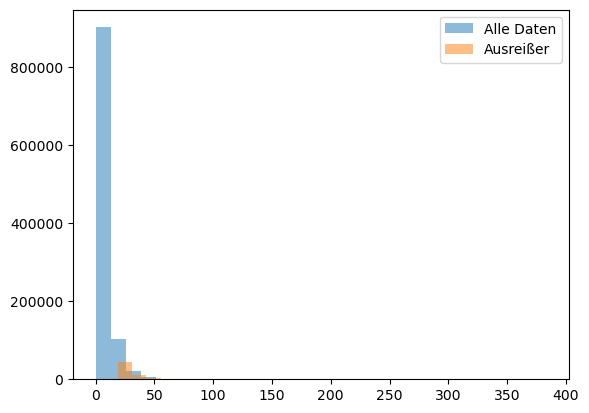

,AGS,Gemeinde,Geschlecht,Altersgruppe_LB,Anzahl_LB,Jahr,Anzahl_Bevoelkerung,SGB2-Quote (%)
541192,6431011,"Heppenheim (Bergstraße), Stadt",w,unter 3 Jahren,59.166667,2018,313.0,18.903088
581764,15091010,"Annaburg, Stadt",m,6 bis unter 15 Jahren,51.416667,2018,272.0,18.903186
626616,1053100,"Ratzeburg, Stadt",w,18 bis unter 25 Jahren,87.333333,2018,462.0,18.903319
415733,12071372,"Spremberg, Stadt",w,unter 3 Jahren,43.666667,2017,231.0,18.903319
529957,5374012,"Gummersbach, Stadt",m,unter 3 Jahren,133.083333,2018,704.0,18.903883
5900,8335075,"Singen (Hohentwiel), Stadt",m,unter 3 Jahren,124.583333,2014,659.0,18.904906
842928,3241010,"Langenhagen, Stadt",w,6 bis unter 15 Jahren,424.416667,2020,2245.0,18.904974
694002,6437009,Höchst i. Odw.,w,3 bis unter 6 Jahren,25.333333,2019,134.0,18.905473
690342,14523340,"Reichenbach im Vogtland, Stadt",m,3 bis unter 6 Jahren,38,2019,201.0,18.905473
196100,14522510,"Roßwein, Stadt",w,6 bis unter 15 Jahren,50.666667,2015,268.0,18.905473


In [38]:
# Histogramm der "SGB2-Quote (%)" Werte erstellen, das die Ausreißer hervorhebt
# Tabellenkopf mit den niedrigsten als Ausreißern identifizierten Werten anzeigen

plt.hist(stacked_lb_bev["SGB2-Quote (%)"], bins=30, alpha=0.5, label='Alle Daten')
plt.hist(outliers["SGB2-Quote (%)"], bins=30, alpha=0.5, label='Ausreißer')
plt.legend(loc='upper right')
plt.show()
outliers.sort_values('SGB2-Quote (%)', ascending=True).head(10)


#### ---> Identifikation auf Grundalge des IQR scheint nicht geeignet, da auch plausible Werte ab 18% als Ausreißer identifiziert werden...

In [45]:
# Alternative: Eigenen SChwellenwert bestimmen

threshold = 40
outliers = stacked_lb_bev[stacked_lb_bev["SGB2-Quote (%)"] > threshold]
num_outliers = len(outliers)
total_values = len(stacked_lb_bev)
outlier_percentage = (num_outliers / total_values) * 100
print("Prozentanteil der Ausreißer mit %-Werten über", threshold, "%:", outlier_percentage)
print("Anzahl der Ausreißer:", num_outliers)
outliers.sort_values('SGB2-Quote (%)', ascending=True).head(10)


Prozentanteil der Ausreißer mit %-Werten über 40 %: 0.7232210793022886
Anzahl der Ausreißer: 7547


,AGS,Gemeinde,Geschlecht,Altersgruppe_LB,Anzahl_LB,Jahr,Anzahl_Bevoelkerung,SGB2-Quote (%)
163180,15082180,"Köthen (Anhalt), Stadt",m,3 bis unter 6 Jahren,118.416667,2015,296.0,40.005631
139643,12068264,"Kyritz, Stadt",m,unter 3 Jahren,44.416667,2015,111.0,40.015015
950693,5113000,"Essen, Stadt",w,3 bis unter 6 Jahren,2726.916667,2021,6814.0,40.019323
397831,3405000,"Wilhelmshaven, Stadt",m,unter 3 Jahren,338.25,2017,845.0,40.029586
670037,1051044,"Heide, Stadt",w,unter 3 Jahren,100.083333,2019,250.0,40.033333
529129,3252006,"Hameln, Stadt",m,unter 3 Jahren,280.25,2018,700.0,40.035714
151426,13075079,Löcknitz,w,unter 3 Jahren,16.416667,2015,41.0,40.04065
693238,3405000,"Wilhelmshaven, Stadt",w,3 bis unter 6 Jahren,316.333333,2019,790.0,40.042194
297707,1058135,"Rendsburg, Stadt",w,3 bis unter 6 Jahren,139.75,2016,349.0,40.04298
569228,12066304,"Senftenberg, Stadt",w,3 bis unter 6 Jahren,100.916667,2018,252.0,40.046296


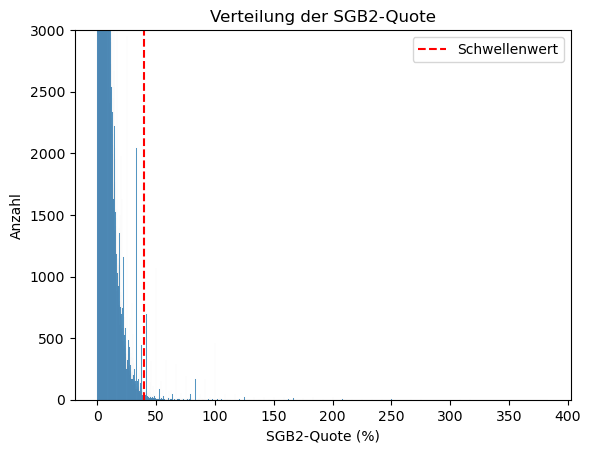

In [42]:
sns.histplot(stacked_lb_bev["SGB2-Quote (%)"])
plt.axvline(x=threshold, color='r', linestyle='--', label='Schwellenwert')
plt.legend()
plt.xlabel("SGB2-Quote (%)")
plt.ylabel("Anzahl")
plt.title("Verteilung der SGB2-Quote")
plt.ylim(0, 3000)
plt.show()

### 3.5 Tabellen exportieren als Excel und CSV

In [30]:
# DataFrame stacked_elb_schul speichern
stacked_elb_schul.to_excel('elb_quote_schul.xlsx', index=False)
stacked_elb_schul.to_csv('elb_quote_schul.csv', index=False)

# DataFrame stacked_elb_beruf speichern
stacked_elb_beruf.to_excel('elb_quote_beruf.xlsx', index=False)
stacked_elb_beruf.to_csv('elb_quote_beruf.csv', index=False)

# DataFrame stacked_lb_bev speichern
stacked_lb_bev.to_excel('sgb2_quote.xlsx', index=False)
stacked_lb_bev.to_csv('sgb2_quote.csv', index=False)

In [31]:
stacked_lb_bev["SGB2-Quote (%)"].describe()

count     1032993.0
unique     236945.0
top             0.0
freq       221511.0
Name: SGB2-Quote (%), dtype: float64